<a href="https://colab.research.google.com/github/tarynduong/personal-projects/blob/main/PortfolioAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

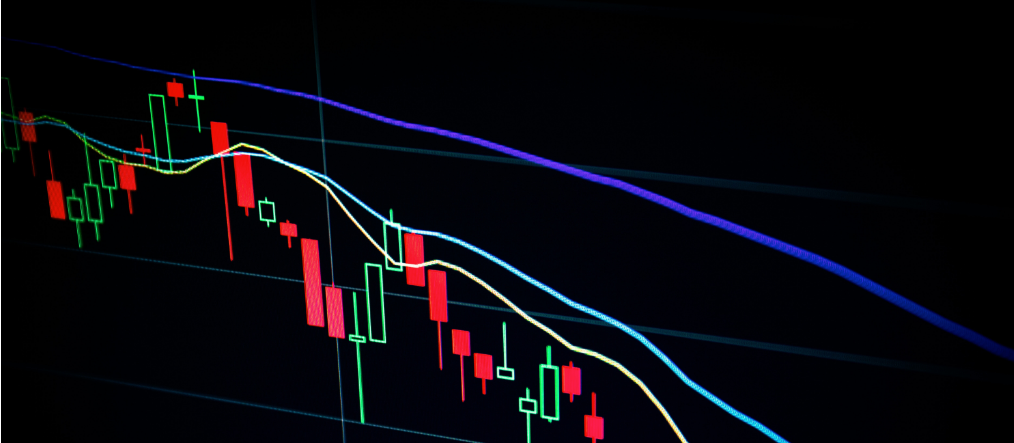

# **README**
## ☁ **Objective**
The report is prepared to help answer the question whether an investment firm should add Bitcoin to their current portfolio, which includes S&P 500 stocks and gold. In doing so, I will analyze returns and risks of Bitcoin and compare it to the other assets, thereby suggest a portfolio consisting of these three asset classes that can satisfy either minimum volatility or maximize risk-adjusted returns.

## 💰 **Sample**
The "ingredients" for this report include daily data on Bitcoin and S&P 500 along with monthly data on US gold price and inflation. Because the observation period of data (Sep 2014 - Nov 2021) is relatively short, it would assuredly not capture a full business cycle. Meanwhile the period captures the initial stage of Bitcoin developing into a mainstream investment and attracting huge investor inflows. Behaviors might differ significantly in the future. 
 
**⚠ Disclaimer**: Data is only used for illustration, that is why you may feel 
Bitcoin trading volume looked somewhat unrealistically high. The analysis relies entirely on past performance data, so it should not be extrapolated into the future. Further findings with forward-looking analysis should also be taken into account before making the final investment decision.

**Source code author**: Duong Minh Truc


# **CODING**

In [ ]:
!pip install --upgrade PyPortfolioOpt --upgrade cvxpy --upgrade cvxopt --no-deps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 3.3 MB/s 


[CVXPY](https://www.cvxpy.org/) is an open source Python-embedded modeling language for **convex optimization** problems. It lets you express your problem in a natural way that follows the math, rather than in the restrictive standard form required by solvers.

In [ ]:
import numpy as np
import pandas as pd
from cvxpy import CVXOPT
from datetime import datetime, timedelta
from scipy import stats
from pypfopt import EfficientFrontier

import matplotlib.pyplot as plt
import matplotlib.ticker as tk
import seaborn as sns

## **1. OVERVIEW**

In [ ]:
# pandas cannot automatically recognize dates, so I have to turn on parse_dates to get data type as datetime
bitcoin = pd.read_csv('bitcoin-usd.csv', parse_dates=['date'])
sp500 = pd.read_csv('sp500.csv', parse_dates=['date'])
gold_cpi = pd.read_csv('monthly_data.csv', parse_dates=['date'])

In [ ]:
print('\033[1m Bitcoin:\n \033[0m', bitcoin.head())
print('-------------------------------------------------------------------------')
print('\033[1m SP 500:\n \033[0m', sp500.head())
print('-------------------------------------------------------------------------')
print('\033[1m Gold price and inflation rate:\n \033[0m', gold_cpi.head())

 Bitcoin:
          date        open        high         low       close      volume
0 2014-09-17  465.864014  468.174011  452.421997  457.334015  21056800.0
1 2014-09-18  456.859985  456.859985  413.104004  424.440002  34483200.0
2 2014-09-19  424.102997  427.834991  384.532013  394.795990  37919700.0
3 2014-09-20  394.673004  423.295990  389.882996  408.903992  36863600.0
4 2014-09-21  408.084991  412.425995  393.181000  398.821014  26580100.0
-------------------------------------------------------------------------
 SP 500:
          date         open         high          low        close      volume
0 2014-09-17  1999.300049  2010.739990  1993.290039  2001.569946  3209420000
1 2014-09-18  2003.069946  2012.339966  2003.069946  2011.359985  3235340000
2 2014-09-19  2012.739990  2019.260010  2006.589966  2010.400024  4880220000
3 2014-09-22  2009.079956  2009.079956  1991.010010  1994.290039  3349670000
4 2014-09-23  1992.780029  1995.410034  1982.770020  1982.770020  3279350000
---

In [ ]:
print('\033[1m                 --- Statistical Report on Numerical Data ---               \033[0m')
def report(df):
  print('Size of dataset:', df.shape)
  numerical = df._get_numeric_data().columns.to_list()
  types = pd.DataFrame(df[numerical].dtypes, columns=['data type'])
  missing_value = pd.DataFrame(df[numerical].isnull().sum(), columns=['missing values'])
  unique_value = pd.DataFrame(df[numerical].nunique(), columns=['unique values'])
  stats = df.describe().T
  report = types.join(missing_value).join(unique_value).join(stats)
  return report

print('\033[1m Bitcoin:\n \033[0m', report(bitcoin))
print('-------------------------------------------------------------------------')
print('\033[1m SP 500:\n \033[0m', report(sp500))
print('-------------------------------------------------------------------------')
print('\033[1m Gold price and inflation rate:\n \033[0m', report(gold_cpi))

                 --- Statistical Report on Numerical Data ---               
Size of dataset: (2619, 6)
 Bitcoin:
         data type  missing values  unique values   count          mean  \
open     float64               4           2611  2615.0  1.005164e+04   
high     float64               4           2612  2615.0  1.033448e+04   
low      float64               4           2614  2615.0  9.750737e+03   
close    float64               4           2612  2615.0  1.007381e+04   
volume   float64               4           2615  2615.0  1.400155e+10   

                 std           min           25%           50%           75%  \
open    1.489243e+04  1.768970e+02  5.820710e+02  5.745599e+03  9.866986e+03   
high    1.532632e+04  2.117310e+02  5.889610e+02  5.865882e+03  1.013700e+04   
low     1.442227e+04  1.715100e+02  5.753120e+02  5.544090e+03  9.642615e+03   
close   1.492307e+04  1.781030e+02  5.825560e+02  5.750800e+03  9.870199e+03   
volume  1.993158e+10  5.914570e+06  7.489110e

There are only 4 missing data points in the bitcoin dataset. The other two dataset have no missing values. Let's check these 4 rows.

In [ ]:
bitcoin[bitcoin.isnull().any(axis=1)]

,date,open,high,low,close,volume
2039,2020-04-17,NaN,NaN,NaN,NaN,NaN
2214,2020-10-09,NaN,NaN,NaN,NaN,NaN
2217,2020-10-12,NaN,NaN,NaN,NaN,NaN
2218,2020-10-13,NaN,NaN,NaN,NaN,NaN


Instead of dropping 4 missing rows, I try interpolation using DatetimeIndex in pandas.

In [ ]:
a = bitcoin[bitcoin['date'].isin(['2020-04-15', '2020-04-16', '2020-04-17', '2020-04-18', '2020-10-08', '2020-10-09', '2020-10-10', '2020-10-11',
                                  '2020-10-12', '2020-10-13','2020-10-14'])]
bitcoin = bitcoin.set_index('date').interpolate(method='time').reset_index()
b = bitcoin[bitcoin['date'].isin(['2020-04-15', '2020-04-16', '2020-04-17', '2020-04-18', '2020-10-08', '2020-10-09', '2020-10-10', '2020-10-11',
                                  '2020-10-12', '2020-10-13','2020-10-14'])]
a.merge(b, on='date', how='inner', suffixes=['_org', '_imp']) # org: original, imp: imputed

,date,open_org,high_org,low_org,close_org,volume_org,open_imp,high_imp,low_imp,close_imp,volume_imp
0,2020-04-15,6845.561523,6928.664551,6633.402832,6642.109863,3.228831e+10,6845.561523,6928.664551,6633.402832,6642.109863,3.228831e+10
1,2020-04-16,6640.454102,7134.450684,6555.504395,7116.804199,4.678324e+10,6640.454102,7134.450684,6555.504395,7116.804199,4.678324e+10
2,2020-04-17,NaN,NaN,NaN,NaN,NaN,6866.372803,7202.203613,6822.375733,7187.234619,3.961522e+10
3,2020-04-18,7092.291504,7269.956543,7089.247070,7257.665039,3.244719e+10,7092.291504,7269.956543,7089.247070,7257.665039,3.244719e+10
4,2020-10-08,10677.625000,10939.799805,10569.823242,10923.627930,2.196212e+10,10677.625000,10939.799805,10569.823242,10923.627930,2.196212e+10
5,2020-10-09,NaN,NaN,NaN,NaN,NaN,10868.383789,11191.005371,10813.381836,11109.994629,2.242005e+10
6,2020-10-10,11059.142578,11442.210938,11056.940430,11296.361328,2.287798e+10,11059.142578,11442.210938,11056.940430,11296.361328,2.287798e+10
7,2020-10-11,11296.082031,11428.813477,11288.627930,11384.181641,1.996863e+10,11296.082031,11428.813477,11288.627930,11384.181641,1.996863e+10
8,2020-10-12,NaN,NaN,NaN,NaN,NaN,11340.403971,11465.868164,11295.028972,11399.290039,2.134689e+10
9,2020-10-13,NaN,NaN,NaN,NaN,NaN,11384.725912,11502.922852,11301.430013,11414.398438,2.272516e+10


In [ ]:
del a, b
bitcoin.isnull().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64

As gold price and inflation are observed on a monthly basis, I conduct monthly resampling on Bitcoin and S&P 500 then merge these two dataframes together on the same date.

In [ ]:
gold_cpi['date'] -= timedelta(days=1) 
gold_cpi.set_index('date', inplace=True)
df = sp500.merge(bitcoin, on='date', how='left', suffixes=['_sp500','_btc']).set_index('date')
df_resample_month = df.resample('M').last() # get the last date of each month
df_final = df_resample_month.merge(gold_cpi, left_index=True, right_index=True)
df_final

,open_sp500,high_sp500,low_sp500,close_sp500,volume_sp500,open_btc,high_btc,low_btc,close_btc,volume_btc,gold_usd,cpi_us
date,,,,,,,,,,,,
2014-09-30,1978.209961,1985.170044,1968.959961,1972.290039,3951100000,376.088013,390.976990,373.442993,386.944000,3.470730e+07,1223.565,238.031
2014-10-31,2001.199951,2018.189941,2001.199951,2018.050049,4292290000,345.009003,348.045013,337.141998,338.321014,1.254540e+07,1176.413,237.433
2014-11-30,2074.780029,2075.760010,2065.060059,2067.560059,2504640000,369.373993,382.838013,358.454987,376.446991,2.294650e+07,1200.440,236.151
2014-12-31,2082.110107,2085.580078,2057.939941,2058.899902,2606070000,310.914001,320.192993,310.210999,320.192993,1.394290e+07,1249.333,234.812
2015-01-31,2019.349976,2023.319946,1993.380005,1994.989990,4568650000,232.772003,242.850998,225.839005,226.425003,2.660520e+07,1231.100,233.707
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-30,4290.649902,4302.430176,4287.959961,4297.500000,3687880000,35908.386719,36074.757813,34086.152344,35040.835938,3.405904e+10,1774.800,271.696
2021-07-31,4395.120117,4412.250000,4389.649902,4395.259766,2861600000,40027.484375,42235.546875,38397.355469,42235.546875,3.307278e+10,1817.000,273.003
2021-08-31,4529.750000,4531.390137,4515.799805,4522.680176,3090380000,47024.339844,48189.550781,46750.093750,47166.687500,3.473036e+10,1816.700,273.567


##**2. EXPLORATORY DATA ANALYSIS**
**a) How did the performance of Bitcoin (i.e. risk and returns) compare to the S&P 500 and gold?**
* Bitcoin strongly outperformed both asset classes since 2014, delivering average annual returns of more than 100%. 
* Bitcoin's outperformance came at the expense of significantly higher risk (across a range of measures like volatility, Value-at-Risk, drawdown or daily trading range). 
* Still, risk-adjusted returns of Bitcoin (with a Sharpe ratio of 1.3) exceeded those of gold (0.4) and S&P 500 (0.9).

In [ ]:
def chart_format(num):
  for i in range(num):
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

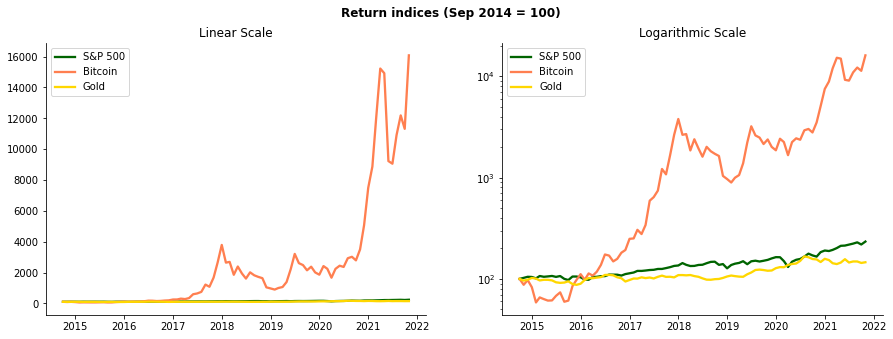

In [ ]:
# Choose color: https://www.maplesoft.com/support/help/maple/view.aspx?path=plot%2Fcolornames
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle('Return indices (Sep 2014 = 100)', fontweight='bold', fontsize=12)

ax[0].plot(df_final.index, df_final.close_sp500*100/df_final.close_sp500[0], color='darkgreen', lw=2.3)
ax[0].plot(df_final.index, df_final.close_btc*100/df_final.close_btc[0], color='coral', lw=2.3)
ax[0].plot(df_final.index, df_final.gold_usd*100/df_final.gold_usd[0], color='gold', lw=2.3)
ax[0].set_title('Linear Scale')
ax[0].legend(['S&P 500', 'Bitcoin', 'Gold'])

# Logarithmic scale is used for clearly showing percent changes 
ax[1].plot(df_final.index, df_final.close_sp500*100/df_final.close_sp500[0], color='darkgreen', lw=2.3)
ax[1].plot(df_final.index, df_final.close_btc*100/df_final.close_btc[0], color='coral', lw=2.3)
ax[1].plot(df_final.index, df_final.gold_usd*100/df_final.gold_usd[0], color='gold', lw=2.3)
plt.yscale('log')
ax[1].set_title('Logarithmic Scale')
ax[1].legend(['S&P 500', 'Bitcoin', 'Gold'])
chart_format(2)

In [ ]:
# Calculate period performance and annualized performance
sp500_perf = (df_final.close_sp500[-1]/df_final.close_sp500[0]) - 1
sp500_perf_annual = (sp500_perf + 1)**(12/len(df_final)) - 1
btc_perf = (df_final.close_btc[-1]/df_final.close_btc[0]) - 1
btc_perf_annual = (btc_perf + 1)**(12/len(df_final)) - 1   
gold_perf = (df_final.gold_usd[-1]/df_final.gold_usd[0]) - 1
gold_perf_annual = (gold_perf + 1)**(12/len(df_final)) - 1   
compare = pd.DataFrame(data=[[btc_perf, sp500_perf,  gold_perf, btc_perf_annual, sp500_perf_annual, gold_perf_annual]],
                       columns=['btc_perf', 'sp500_perf', 'gold_perf', 'btc_perf_annual', 'sp500_perf_annual', 'gold_perf_annual'])
compare

,btc_perf,sp500_perf,gold_perf,btc_perf_annual,sp500_perf_annual,gold_perf_annual
0,159.819046,1.335042,0.459097,1.031707,0.125615,0.054133


▶ **Insights:**
Clearly, 2014 to 2016 was the fallow period when Bitcoin price was still lower than gold and stocks, it began to climb with the second halving in 2016, and quickly reached five digits within the year after the halving. Over the last 7 years, annualized performance of gold was seeing +5.4% and that of S&P 500 was showing +12.5%. Both these benchmarks pale in comparison to Bitcoin, peaking at +103.4% in October 2021. Bitcoin's value increased by a factor of roughly 160x, compared to 1.3x for the S&P 500 and 0.5x for gold.



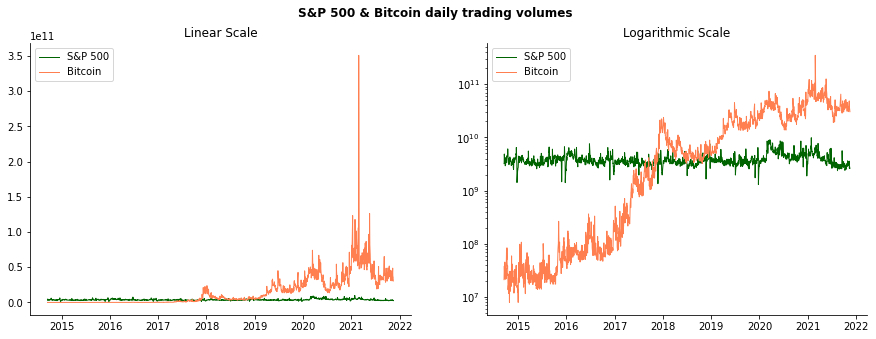

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle('S&P 500 & Bitcoin daily trading volumes', fontweight='bold', fontsize=12)

ax[0].plot(df.index, df.volume_sp500, label='S&P 500', color='darkgreen', lw=1)
ax[0].plot(df.index, df.volume_btc, label='Bitcoin', color='coral', lw=1)
ax[0].legend()
ax[0].set_title('Linear Scale')

ax[1].plot(df.index, df.volume_sp500, label='S&P 500', color='darkgreen', lw=1)
ax[1].plot(df.index, df.volume_btc, label='Bitcoin', color='coral', lw=1)
plt.yscale('log')
ax[1].legend()
ax[1].set_title('Logarithmic Scale')
chart_format(2)

▶ **Insights:** 
* "Bitcoin’s unprecedented performance has driven exponential adoption of cryptocurrencies as a new asset class that merits an allocation in any forward-looking investor’s portfolio." - [the Nasdaq news](https://www.nasdaq.com/articles/bitcoin-vfastly-outperformed-gold-and-sp-500-over-the-past-decade). This statement is true, at least in the observed time period.
* While trading volume of S&P 500 stocks was relatively stable, it has risen sharply for Bitcoin. By late-2017, daily S&P 500 trading volume still exceeded Bitcoin's, however, the throne was soon given up to Bitcoin since then.

Text(4.34, -0.88, '-74%')

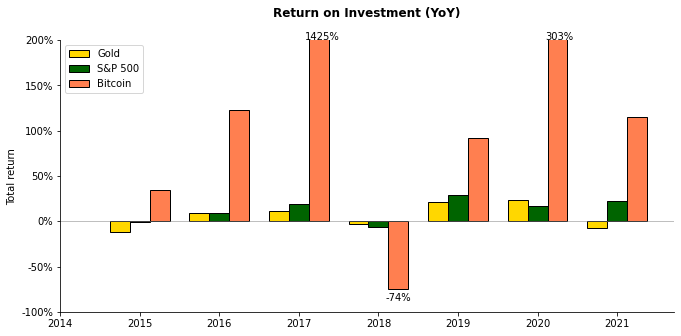

In [ ]:
fig, ax = plt.subplots(figsize=(11, 5))
plt.title('Return on Investment (YoY)', pad=23, fontweight='bold')

annual = df_final.resample('Y').last()
years = annual.index.year
x_axis = np.arange(len(years))

plt.bar(x_axis, annual.gold_usd.pct_change(), width=.25, label='Gold', color='gold', edgecolor='black')
plt.bar(x_axis + .25, annual.close_sp500.pct_change(), width=.25, label='S&P 500', color='darkgreen', edgecolor='black')
plt.bar(x_axis + .5, annual.close_btc.pct_change(), width=.25, label='Bitcoin', color='coral', edgecolor='black')

plt.xticks(x_axis + .25, years)
plt.ylim([-1, 2])
ax.yaxis.set_major_formatter(tk.PercentFormatter(1))
plt.legend(loc='upper left')
plt.ylabel('Total return')
plt.axhline(y=0, color='grey', linewidth=.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.annotate('1425%', (3.33, 2), color='black') # annual.close_btc.pct_change()[3] = 14.25
ax.annotate('303%', (6.35, 2), color='black') # annual.close_btc.pct_change()[6] = 3.03
ax.annotate('-74%', (4.34, -.88), color='black') # annual.close_btc.pct_change()[6] = -0.74

▶ **Insights:** 
Except 2018, Bitcoin always outperformed in every year, especially in 2017 (+1425%) and 2020 (+303%). 

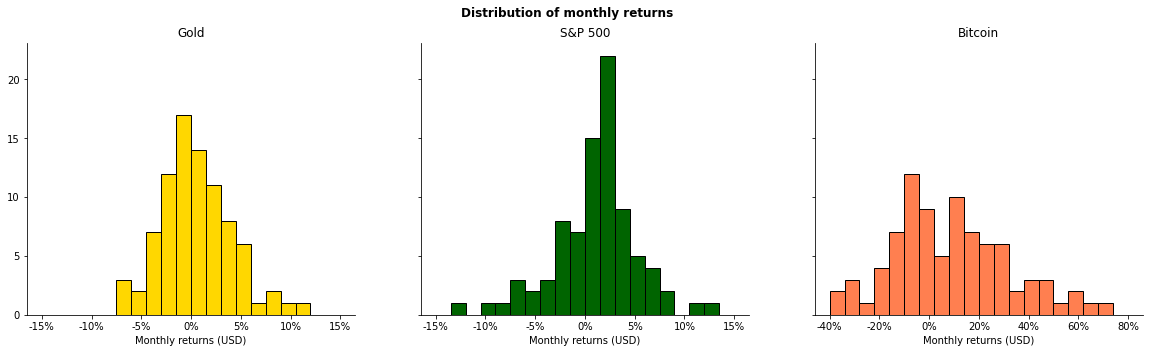

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
plt.suptitle('Distribution of monthly returns', fontweight='bold', fontsize=12)

ax[0].hist(df_final.gold_usd.pct_change(), bins=20, range=[-.15, .15], edgecolor='black', color='gold')
ax[0].xaxis.set_major_formatter(tk.PercentFormatter(1, decimals=0))
ax[0].set_title('Gold')
ax[0].set_xlabel('Monthly return (USD)')

ax[1].hist(df_final.close_sp500.pct_change(), bins=20, range=[-.15, .15], edgecolor='black', color='darkgreen')
ax[1].xaxis.set_major_formatter(tk.PercentFormatter(1, decimals=0))
ax[1].set_title('S&P 500')
ax[1].set_xlabel('Monthly return (USD)')

ax[2].hist(df_final.close_btc.pct_change(), bins=20, range=[-.4, .8], edgecolor='black', color='coral')
ax[2].xaxis.set_major_formatter(tk.PercentFormatter(1, decimals=0))
ax[2].set_title('Bitcoin')
ax[2].set_xlabel('Monthly return (USD)')
chart_format(3)

▶ **Insights:** 
* **Range of value**: range of monthly return is much larger for Bitcoin (-40% to 80%) than for S&P 500 and gold (-15% to 15%).
* **Distribution**: monthly return of stocks and gold appear almost normal with a mean value around zero, indeed slightly positive skew for S&P 500 and negative skew for gold. In contrast, distribution of Bitcoin return is much flatter in tails, which indicates that extreme outcomes will commonly occur for Bitcoin. Bitcoin's returns at this time tended to be positive more often than negative.

**📓 Basic Nomenclature**
* **Sharpe ratio**: the average return earned in excess of the risk-free rate per unit of volatility or total risk.
This measure is used to help investors understand the return of an investment compared to its risk.
* **Drawdown**: how much an investment or trading account is down from the peak before it recovers back to the peak. Drawdowns are typically quoted as a percentage, but dollar terms may also be used if applicable for a specific trader. Drawdowns are a measure of downside volatility.
* **Value at Risk**: a statistic that quantifies the extent of possible financial losses within a firm, portfolio, or position over a specific time frame. This metric is determined by three variables, including a specific time period, a confidence level, and the size of the possible loss.
* **Expected shortfall**: an alternative to value at risk that is more sensitive to the shape of the tail of the loss distribution of returns on a portfolio, unlike the more commonly used value-at-risk (VAR). Expected shortfall is calculated by averaging all of the returns in the distribution that are worse than the VAR of the portfolio at a given level of confidence.

▶ **Note**: VaR and Conditional VaR have their own drawbacks, such as the implicit assumption of normal distribution. 

In [ ]:
stats = {'Annual return (%)': [round(gold_perf_annual*100, 1), round(sp500_perf_annual*100, 1), round(btc_perf_annual*100, 1)],
         'Annual volatility (%)': [round(df_final.gold_usd.pct_change().std()*(12**.5)*100, 1), round(df_final.close_sp500.pct_change().std()*(12**.5)*100, 1),
                                   round(df_final.close_btc.pct_change().std()*(12**.5)*100, 1)],
         'Sharpe ratio': [round(gold_perf_annual/(df_final.gold_usd.pct_change().std()*(12**.5)), 1),
                          round(sp500_perf_annual/(df_final.close_sp500.pct_change().std()*(12**.5)), 1),
                          round(btc_perf_annual/(df_final.close_btc.pct_change().std()*(12**.5)), 1)],
         'Monthly drawdown (%)': [round(min(df_final.gold_usd / df_final.gold_usd.expanding().max() - 1)*100, 1),
                                  round(min(df_final.close_sp500 / df_final.close_sp500.expanding().max() - 1)*100, 1),
                                  round(min(df_final.close_btc / df_final.close_btc.expanding().max() - 1)*100, 1)],
         'Daily drawdown (%)': [np.nan, round(min(df.close_sp500 / df.close_sp500.expanding().max() - 1)*100, 1),
                                round(min(df.close_btc / df.close_btc.expanding().max() - 1)*100, 1)],
         'VaR(95) (%)': [round(df_final.gold_usd.pct_change().nsmallest(5)[-1]*100, 1), round(df_final.close_sp500.pct_change().nsmallest(5)[-1]*100, 1),
                         round(df_final.close_btc.pct_change().nsmallest(5)[-1]*100, 1)],
         'CVaR(95) / Expected shortfall (%)': [round(df_final.gold_usd.pct_change().nsmallest(4).mean()*100, 1),
                                               round(df_final.close_sp500.pct_change().nsmallest(4).mean()*100, 1),
                                               round(df_final.close_btc.pct_change().nsmallest(4).mean()*100, 1)]}
stats_df = pd.DataFrame(stats).T
stats_df.columns = ['Gold', 'S&P 500', 'Bitcoin']
print('\033[1m         Asset class risk analysis (2014-2021) \033[0m')
stats_df

         Asset class risk analysis (2014-2021) 


,Gold,S&P 500,Bitcoin
Annual return (%),5.4,12.6,103.2
Annual volatility (%),12.6,14.4,82.5
Sharpe ratio,0.4,0.9,1.3
Monthly drawdown (%),-16.1,-20.0,-76.4
Daily drawdown (%),NaN,-33.9,-83.0
VaR(95) (%),-5.7,-6.6,-29.3
CVaR(95) / Expected shortfall (%),-6.8,-9.3,-34.0


▶ **Insights:** 
* In short, Bitcoin came with significantly higher risk across all metrics. Bitcoin's annualized volatility (based on monthly data) was a whopping 82.5% compared to 14.4% for stocks. 
* The daily drawdown realized over the period was -83% compared to -34% for the S&P 500. Still, on risk-adjusted returns, as measured by the Sharpe ratio, Bitcoin's 1.3 compares favorably to both US stocks (0.9) and gold (0.4).
* Given that volatility only measures short-term fluctuations in value while the only true risk ultimately is the permanent loss of capital, I added the historic Value-at-Risk (VaR) for the 95% confidence interval: Bitcoin's VaR of -29.3% has been more than 4 time that of S&P 500. 
* Finally, "expected shortfall" measures the mean loss below the VaR and gives another indication of Bitcoin's significant tail risk: -34% for Bitcoin versus -9.3% for S&P 500.


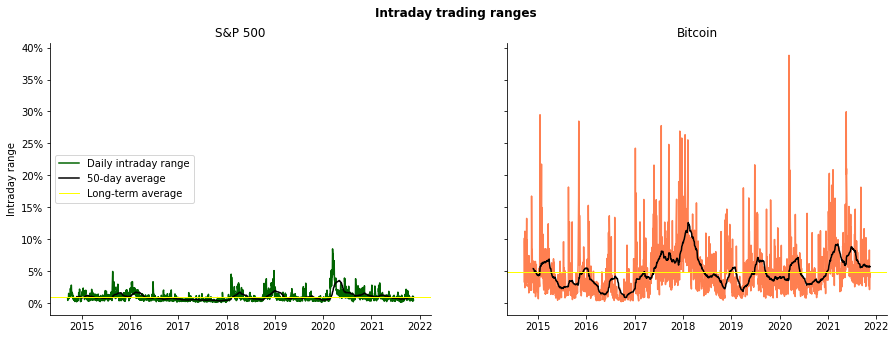

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
plt.suptitle('Intraday trading ranges', fontweight='bold', fontsize=12)

ax[0].plot(df.index, ((df.high_sp500 - df.low_sp500) / df.open_sp500), color='darkgreen', label='Daily intraday range')
ax[0].plot(df.index, ((df.high_sp500 - df.low_sp500) / df.open_sp500).rolling(50).mean(), color='black', label='50-day average')
ax[0].axhline(y=((df.high_sp500 - df.low_sp500) / df.open_sp500).mean(), color='yellow', linewidth=1, label='Long-term average')
ax[0].set_title('S&P 500', fontsize=12)
ax[0].yaxis.set_major_formatter(tk.PercentFormatter(1, decimals=0))
ax[0].set_ylabel('Intraday range')
ax[0].legend(loc='center left')

ax[1].plot(df.index, (df.high_btc - df.low_btc) / df.open_btc, color='coral', label='Daily intraday range')
ax[1].plot(df.index, ((df.high_btc - df.low_btc) / df.open_btc).rolling(50).mean(), color='black', label='50-day average')
ax[1].axhline(y=((df.high_btc - df.low_btc) / df.open_btc).mean(), color='yellow', linewidth=1, label='Long-term average')
ax[1].set_title('Bitcoin', fontsize=12)
chart_format(2)

▶ **Insights:** 
Another way to highlight Bitcoin's liquidation risk is to look at its intraday volatility compared to S&P 500. The long-term average was 4.9% for Bitcoin and 1% for the S&P 500. More interesting are the spikes, which reached 30-40% for Bitcoin on extreme days - a far cry from what was observed for stocks. Such large intraday swings can potentially cause challenging issues for risk management.

**b) How does the inclusion of Bitcoin change portfolio's characteristics and can it help improve a portfolio's performance?**
* In light of the analysis in a), it is not surprising that the inclusion of Bitcoin would have increased a portfolio's risk and return significantly. 
* Bitcoin's correlation to US equities has been mildly positive since 2014 (with a correlation coefficient of 0.3), thus offering limited diversification benefits. 
* Bitcoin could help increase portfolio returns, but only at the expense of higher risk.

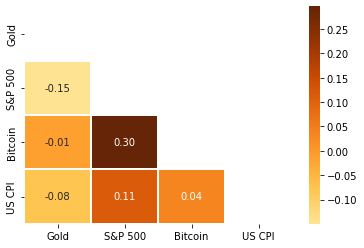

In [ ]:
corr_df = df_final[['gold_usd', 'close_sp500', 'close_btc', 'cpi_us']].pct_change().dropna()
corr_df.columns = ['Gold', 'S&P 500', 'Bitcoin', 'US CPI']
mask = np.triu(np.ones_like(corr_df.corr(), dtype=bool))
sns.heatmap(corr_df.corr(), mask=mask, center=0, linewidths=1, annot=True, fmt='.2f', cmap='YlOrBr')

▶ **Insights:** 
Gold is the only factor that negatively correlated with the rest of assets and inflation rate. The pair with the highest correlation coefficient was Bitcoin and S&P 500 (0.3), which indicates that Bitcoin was likely (but weak) to move in the same direction as stocks, thus offering limited diversification benefits in a portfolio with equities.

## **2. PORTFOLIO ANALYSIS**
**a) Could Bitcoin be used as a hedge against inflation?**
* No. There has been no consistent relationship between monthly changes in the general US consumer price level and the price of Bitcoin. 
* On the positive side, Bitcoin will not consistently suffer from rising (or falling) inflation. But it also does not consistently gain in an environment of high inflation, thus not offering good hedging properties. 
* It's worth noting that inflation has been relatively low throughout the observation period. So, how Bitcoin will behave under structurally high inflation remains to be seen.

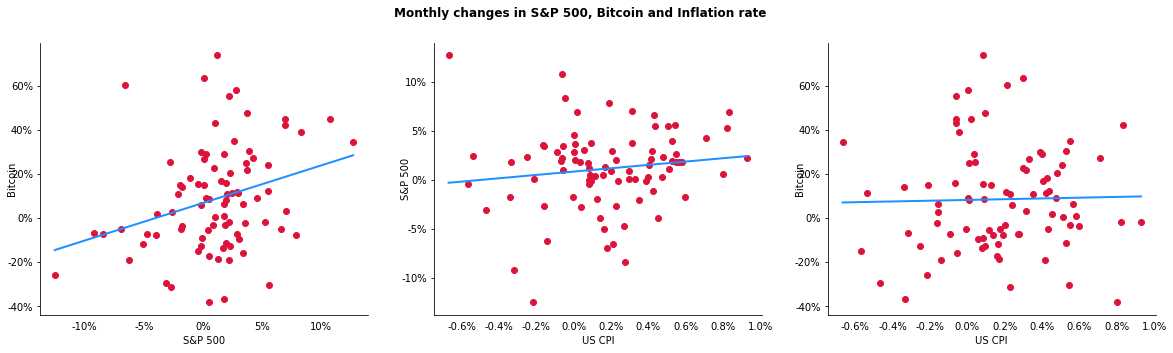

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
plt.suptitle('Monthly changes in S&P 500, Bitcoin and Inflation rate', fontweight='bold', fontsize=12)

ax[0].scatter(corr_df['S&P 500'], corr_df['Bitcoin'], color='crimson')
ax[0].set_xlabel('S&P 500')
ax[0].set_ylabel('Bitcoin', labelpad=-10)
ax[0].xaxis.set_major_formatter(tk.PercentFormatter(1, decimals=0))
ax[0].yaxis.set_major_formatter(tk.PercentFormatter(1, decimals=0))
ax[0].tick_params(bottom=False)
fx = np.array([corr_df['S&P 500'].min(), corr_df['S&P 500'].max()])
fy = stats.linregress(corr_df['S&P 500'], corr_df['Bitcoin']).intercept + stats.linregress(corr_df['S&P 500'], corr_df['Bitcoin']).slope*fx
ax[0].plot(fx, fy, color='dodgerblue', lw=2)

ax[1].scatter(corr_df['US CPI'], corr_df['S&P 500'], color='crimson')
ax[1].set_xlabel('US CPI')
ax[1].set_ylabel('S&P 500', labelpad=-10)
ax[1].xaxis.set_major_formatter(tk.PercentFormatter(1, decimals=1))
ax[1].yaxis.set_major_formatter(tk.PercentFormatter(1, decimals=0))
ax[1].tick_params(bottom=False)
fx = np.array([corr_df['US CPI'].min(), corr_df['US CPI'].max()])
fy = stats.linregress(corr_df['US CPI'], corr_df['S&P 500']).intercept + stats.linregress(corr_df['S&P 500'], corr_df['Bitcoin']).slope*fx
ax[1].plot(fx, fy, color='dodgerblue', lw=2)

ax[2].scatter(corr_df['US CPI'], corr_df['Bitcoin'], color='crimson')
ax[2].set_xlabel('US CPI')
ax[2].set_ylabel('Bitcoin', labelpad=-10)
ax[2].xaxis.set_major_formatter(tk.PercentFormatter(1, decimals=1))
ax[2].yaxis.set_major_formatter(tk.PercentFormatter(1, decimals=0))
ax[2].tick_params(bottom=False)
fx = np.array([corr_df['US CPI'].min(), corr_df['US CPI'].max()])
fy = stats.linregress(corr_df['US CPI'], corr_df['Bitcoin']).intercept + stats.linregress(corr_df['S&P 500'], corr_df['Bitcoin']).slope*fx
ax[2].plot(fx, fy, color='dodgerblue', lw=2)
chart_format(3)

▶ **Insights:** 
Based on the heatmap and scatter plots above, it is clear that Bitcoin itself did not offer good hedging properties against inflation since changes in Bitcoin price were not affected by inflation from 2014 to 2021.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  """
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


 Bitcoin (>= 90th quantile):
  date
2015-03-31   -0.037837
2017-01-31    0.009535
2019-03-31    0.063191
2021-02-28    0.350368
2021-03-31    0.271453
2021-04-30   -0.019835
2021-05-31   -0.381862
2021-06-30   -0.018398
2021-10-31    0.421025
Name: Bitcoin, dtype: float64
--------------------------------
 Bitcoin (10th - 90th quantiles):
  date
2015-02-28    0.121025
2015-04-30   -0.033080
2015-05-31    0.004027
2015-06-30    0.109559
2015-07-31    0.082023
                ...   
2020-12-31    0.477732
2021-01-31    0.183253
2021-07-31    0.205324
2021-08-31    0.116753
2021-09-30   -0.071572
Name: Bitcoin, Length: 67, dtype: float64
--------------------------------
 Bitcoin (<= 10th quantiles):
  date
2014-10-31   -0.125659
2014-11-30    0.112692
2014-12-31   -0.149434
2015-01-31   -0.292848
2015-12-31    0.141116
2018-11-30   -0.364116
2018-12-31   -0.068347
2020-03-31   -0.257575
2020-04-30    0.344779
Name: Bitcoin, dtype: float64


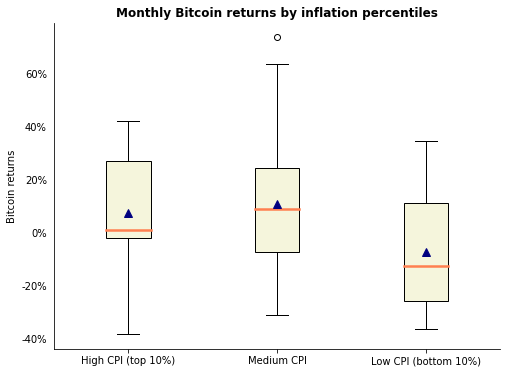

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.title('Monthly Bitcoin returns by inflation percentiles', fontweight='bold', fontsize=12)

btc_90perc = corr_df['Bitcoin'][corr_df['US CPI'] >= np.percentile(corr_df['US CPI'], 90)]
btc_between = corr_df['Bitcoin'][corr_df['US CPI'].between(np.percentile(corr_df['US CPI'], 10), np.percentile(corr_df['US CPI'], 90), inclusive=False)]
btc_10perc = corr_df['Bitcoin'][corr_df['US CPI'] <= np.percentile(corr_df['US CPI'], 10)]
print('\033[1m Bitcoin (>= 90th quantile):\n \033[0m', btc_90perc)
print('--------------------------------')
print('\033[1m Bitcoin (10th - 90th quantiles):\n \033[0m', btc_between)
print('--------------------------------')
print('\033[1m Bitcoin (<= 10th quantiles):\n \033[0m', btc_10perc)

ax.boxplot([btc_90perc, btc_between, btc_10perc], labels=['High CPI (top 10%)', 'Medium CPI', 'Low CPI (bottom 10%)'], showfliers=True, showmeans=True,
           patch_artist=True, boxprops=dict(facecolor='beige'), medianprops=dict(color='coral', linewidth=2.5),
           meanprops=dict(markerfacecolor='navy', markeredgecolor='navy', markersize=8))
"""
showfliers: show the outliers beyond the caps.
patch_artist: if False produces boxes with the Line2D artist; otherwise, boxes and drawn with Patch artists. 
To colorize the boxplot, we need to first use the patch_artist=True keyword to tell it that boxes are patches and not just paths.
FYI: https://stackoverflow.com/questions/41997493/python-matplotlib-boxplot-color
"""
ax.set_ylabel('Bitcoin returns')
ax.yaxis.set_major_formatter(tk.PercentFormatter(1, decimals=0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(left=False)

▶ **Insights:** 
* Bitcoin returns, when inflation is particularly high (i.e. in its 90th percentile) have not been significantly different from Bitcoin returns, when inflation is medium. In fact, both mean (triangle) and median (line) returns have actually been somewhat lower in high inflation months. 
* Also, the range of outcomes under low inflation is the widest and the most negative outcome actually occurred under low inflation. Therefore, this complements the findings that Bitcoin did not offer reliable protection against inflation. Bitcoin returns have been lower (on mean, median and interquartile range), when inflation was subdued (i.e. in the 10th percentile).
* The low/high percentiles contain just 9 observations each! Results are pretty sensitive to the choice of percentile cutoff, however, they actually do not improve when using other cutoff points.

**b) In light of our fund's goal to minimize risk: What is the minimum volatility portfolio, consisting of these three asset classes? And for comparison: Which portfolio would maximize risk-adjusted returns?**
* At the present, portfolio minimizing volatility consisted of 40% US stocks, 60% gold and no Bitcoin. This portfolio achieved a volatility of 8.8% p.a. since 2014 and a Sharpe ratio of close to 1.0. 
* The maximum Sharpe ratio of 1.46 would have been achieved with an allocation of 42% to US stocks, 56% to gold and 2% to Bitcoin.

In [ ]:
# Portfolio volatility for pre-defined allocations
vola = []
returns = []
vola_df = pd.DataFrame()

for i in range(0, 120, 20):
  for j in range(0, 120, 20):
    if i + j <= 100:
      w_sp500 = i / 100
      w_btc = j / 100
      w_gold = 1 - w_sp500 - w_btc
      portfolio = ((w_sp500**2)*((df_final.close_sp500.pct_change().std()*(12**.5))**2) + (w_btc**2)*((df_final.close_btc.pct_change().std()*(12**.5))**2) +
                   (w_gold**2)*((df_final.gold_usd.pct_change().std()*(12**.5))**2) +
                   (2*w_sp500*w_btc*(df_final.close_sp500.pct_change().std()*(12**.5))*(df_final.close_btc.pct_change().std()*(12**.5))*(corr_df.corr().iloc[2, 1])) +
                   (2*w_sp500*w_gold*(df_final.close_sp500.pct_change().std()*(12**.5))*(df_final.gold_usd.pct_change().std()*(12**.5))*(corr_df.corr().iloc[1, 0])) +
                   (2*w_btc*w_gold*(df_final.close_btc.pct_change().std()*(12**.5))*(df_final.gold_usd.pct_change().std()*(12**.5))*(corr_df.corr().iloc[2, 0]))) ** .5
      portfolio_returns = w_sp500*sp500_perf_annual + w_btc*btc_perf_annual + w_gold*gold_perf_annual
      vola.append(portfolio*100)
      returns.append(portfolio_returns*100)
    else:
      vola.append(np.nan)
      returns.append(np.nan)

vola_df['0% Stock'] = vola[0:6]
vola_df['20% Stock'] = vola[6:12]
vola_df['40% Stock'] = vola[12:18]
vola_df['60% Stock'] = vola[18:24]
vola_df['80% Stock'] = vola[24:30]
vola_df['100% Stock'] = vola[30:36]

vola_df.set_index(pd.Index(['0% Bitcoin','20% Bitcoin','40% Bitcoin','60% Bitcoin','80% Bitcoin','100% Bitcoin']), inplace=True)
pd.set_option('precision', 1)

print('\033[1m       Portfolio volatility Matrix for Different Allocations (in % p.a.) \033[0m')
print('*The allocation of gold is the residual that make portfolio weights add up to 100%')
display(vola_df.style.highlight_min(axis=None, color='lightgreen').highlight_max(axis=None, color='coral'))

       Portfolio volatility Matrix for Different Allocations (in % p.a.) 
*The allocation of gold is the residual that make portfolio weights add up to 100%


,0% Stock,20% Stock,40% Stock,60% Stock,80% Stock,100% Stock
0% Bitcoin,12.6,10.0,8.8,9.3,11.4,14.4
20% Bitcoin,19.2,18.9,19.4,20.7,22.7,nan
40% Bitcoin,33.8,34.2,35.1,36.5,nan,nan
60% Bitcoin,49.7,50.4,51.5,nan,nan,nan
80% Bitcoin,66.0,66.9,nan,nan,nan,nan
100% Bitcoin,82.5,nan,nan,nan,nan,nan


▶ **Insights:** Any allocation to Bitcoin increases portfolio volatility significantly. Noting that the minimum volatility is achieved if the portfolio is a combination of 40% stock and 60% gold, which is better than either pure stock (14.4) or pure gold (12.6).

In [ ]:
return_df = pd.DataFrame()
return_df['0% Stock'] = returns[0:6]
return_df['20% Stock'] = returns[6:12]
return_df['40% Stock'] = returns[12:18]
return_df['60% Stock'] = returns[18:24]
return_df['80% Stock'] = returns[24:30]
return_df['100% Stock'] = returns[30:36]

return_df.set_index(pd.Index(['0% Bitcoin','20% Bitcoin','40% Bitcoin','60% Bitcoin','80% Bitcoin','100% Bitcoin']), inplace=True)

sharpe_df = return_df / vola_df
pd.set_option('precision', 2)

print('\033[1m            Portfolio Sharpe ratio Matrix for different allocations \033[0m')
print('*The allocation of gold is the residual that make portfolio weights add up to 100% \n**Assumming a risk-free rate of zero')
display(sharpe_df.style.highlight_max(axis=None, color='yellow'))

            Portfolio Sharpe ratio Matrix for different allocations 
*The allocation of gold is the residual that make portfolio weights add up to 100% 
**Assumming a risk-free rate of zero


,0% Stock,20% Stock,40% Stock,60% Stock,80% Stock,100% Stock
0% Bitcoin,0.43,0.68,0.94,1.04,0.98,0.88
20% Bitcoin,1.30,1.40,1.44,1.41,1.35,nan
40% Bitcoin,1.32,1.34,1.35,1.34,nan,nan
60% Bitcoin,1.29,1.30,1.30,nan,nan,nan
80% Bitcoin,1.27,1.27,nan,nan,nan,nan
100% Bitcoin,1.25,nan,nan,nan,nan,nan


▶ **Insights:** In contrast to the case of minimum volatility, a certain allocation to Bitcoin should be added into portfolio if the purpose is to optimize returns. The highest risk-adjusted return among these pre-defined allocations would be gained with a 40% equity, 20% Bitcoin and 40% gold portfolio (Sharpe ratio of 1.44). Next, I will use random sampling to approximate the efficient frontier and introduce a new optimal asset allocation for the firm.

In [ ]:
risk_return = {}
risk_weights = {}

np.random.seed(1)

for i in np.random.uniform(0, 0.99, 1000):
  w_sp500 = round(i, 4)
  w_btc = np.random.randint(100 - w_sp500*100) / 100
  w_gold = 1 - w_sp500 - w_btc
  portfolio = ((w_sp500**2)*((df_final.close_sp500.pct_change().std()*(12**.5))**2) + (w_btc**2)*((df_final.close_btc.pct_change().std()*(12**.5))**2) +
               (w_gold**2)*((df_final.gold_usd.pct_change().std()*(12**.5))**2) +
               (2*w_sp500*w_btc*(df_final.close_sp500.pct_change().std()*(12**.5))*(df_final.close_btc.pct_change().std()*(12**.5))*(corr_df.corr().iloc[2, 1])) +
               (2*w_sp500*w_gold*(df_final.close_sp500.pct_change().std()*(12**.5))*(df_final.gold_usd.pct_change().std()*(12**.5))*(corr_df.corr().iloc[1, 0])) +
               (2*w_btc*w_gold*(df_final.close_btc.pct_change().std()*(12**.5))*(df_final.gold_usd.pct_change().std()*(12**.5))*(corr_df.corr().iloc[2, 0]))) ** .5
  portfolio_returns = w_sp500*sp500_perf_annual + w_btc*btc_perf_annual + w_gold*gold_perf_annual

  risk_return[portfolio] = portfolio_returns
  risk_weights[portfolio] = w_sp500, w_gold, w_btc

risk_return_df = pd.DataFrame(list(risk_return.items()),columns = ['Ptf volatility','Ptf return']) 
risk_weights_df = pd.DataFrame(list(risk_weights.items()),columns = ['Ptf volatility','Asset class weights']) 
risk_return_df['Ptf Sharpe'] = risk_return_df['Ptf return'] / risk_return_df['Ptf volatility']
portfolio_df = risk_return_df.merge(risk_weights_df)

In [ ]:
min_vola = portfolio_df['Ptf volatility'].min()
max_SR = portfolio_df['Ptf Sharpe'].max()

#Summary table
Opt_ptfs1 = {'Equity weight (%)': [round(portfolio_df['Asset class weights'][portfolio_df['Ptf volatility'] == min_vola].reset_index()['Asset class weights'][0][0]*100, 0),
                                   round(portfolio_df['Asset class weights'][portfolio_df['Ptf Sharpe'] == max_SR].reset_index()['Asset class weights'][0][0]*100, 0)], 
            'Gold weight (%)': [round(portfolio_df['Asset class weights'][portfolio_df['Ptf volatility'] == min_vola].reset_index()['Asset class weights'][0][1]*100, 0),
                                round(portfolio_df['Asset class weights'][portfolio_df['Ptf Sharpe'] == max_SR].reset_index()['Asset class weights'][0][1]*100, 0)],
            'Bitcoin weight (%)': [round(portfolio_df['Asset class weights'][portfolio_df['Ptf volatility'] == min_vola].reset_index()['Asset class weights'][0][2]*100, 0),
                                   round(portfolio_df['Asset class weights'][portfolio_df['Ptf Sharpe'] == max_SR].reset_index()['Asset class weights'][0][2]*100, 0)],
            'Annual ptf return (%)': [round(portfolio_df['Ptf return'][portfolio_df['Ptf volatility'] == min_vola].iloc[0]*100, 2),
                                      round(portfolio_df['Ptf return'][portfolio_df['Ptf Sharpe'] == max_SR].iloc[0]*100, 2)],
            'Annual ptf volatility  (%)': [round(min_vola*100,2), round(portfolio_df['Ptf volatility'][portfolio_df['Ptf Sharpe'] == max_SR].iloc[0]*100, 2)], 
            'Ptf Sharpe ratio': [round(portfolio_df['Ptf Sharpe'][portfolio_df['Ptf volatility'] == min_vola].iloc[0],2), round(max_SR, 2)] }

Opt_ptfs1_df = pd.DataFrame(Opt_ptfs1).T
Opt_ptfs1_df.columns = ['Min volatility ptf', 'Max Sharpe ptf']

print('\033[1m Minimum volatility and maximum Sharpe ratio portfolios (approximated by random sampling)\033[0m')
display(Opt_ptfs1_df)

 Minimum volatility and maximum Sharpe ratio portfolios (approximated by random sampling)


,Min volatility ptf,Max Sharpe ptf
Equity weight (%),51.00,46.00
Gold weight (%),49.00,41.00
Bitcoin weight (%),0.00,13.00
Annual ptf return (%),9.06,21.43
Annual ptf volatility (%),8.84,14.69
Ptf Sharpe ratio,1.02,1.46


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.11, 0.213, 'Max SR')

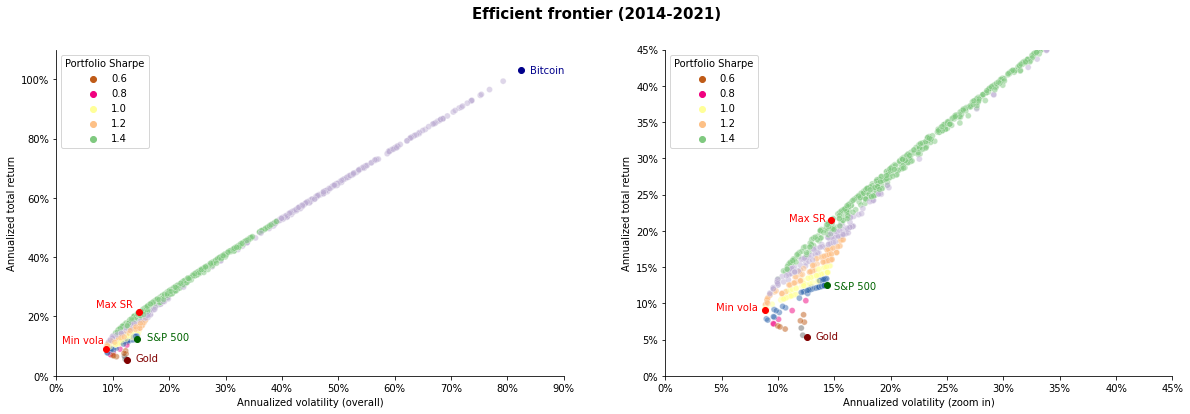

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
plt.suptitle('Efficient frontier (2014-2021)', fontweight='bold', fontsize=15)

sns.scatterplot(portfolio_df['Ptf volatility'], portfolio_df['Ptf return'], ax=ax[0], hue=portfolio_df['Ptf Sharpe'], palette='Accent_r', alpha=.5)
ax[0].scatter(df_final.gold_usd.pct_change().std()*(12**.5), gold_perf_annual, color='maroon')
ax[0].scatter(df_final.close_sp500.pct_change().std()*(12**.5), sp500_perf_annual, color='darkgreen')
ax[0].scatter(df_final.close_btc.pct_change().std()*(12**.5), btc_perf_annual, color='darkblue')
ax[0].set_xlabel('Annualized volatility (overall)')
ax[0].set_ylabel('Annualized total return')
ax[0].xaxis.set_major_formatter(tk.PercentFormatter(1, decimals=0))
ax[0].yaxis.set_major_formatter(tk.PercentFormatter(1, decimals=0))
ax[0].set_ylim([0, 1.1])
ax[0].set_xlim([0, .9])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].legend(loc='upper left', title='Portfolio Sharpe')
ax[0].annotate('S&P 500', (.16, .12), color='darkgreen')
ax[0].annotate('Bitcoin', (.84, 1.02), color='darkblue')
ax[0].annotate('Gold', (.14, .05), color='maroon')
ax[0].scatter(min_vola, portfolio_df['Ptf return'][portfolio_df['Ptf volatility'] == min_vola].iloc[0], color='red')
ax[0].scatter(portfolio_df['Ptf volatility'][portfolio_df['Ptf Sharpe'] == max_SR].iloc[0],
              portfolio_df['Ptf return'][portfolio_df['Ptf Sharpe'] == max_SR].iloc[0], color='red')
ax[0].annotate('Min vola', (.01, .11), color='red')
ax[0].annotate('Max SR', (.07, .23), color='red')

sns.scatterplot(portfolio_df['Ptf volatility'], portfolio_df['Ptf return'], ax=ax[1], hue=portfolio_df['Ptf Sharpe'], palette='Accent_r', alpha=.5)
ax[1].scatter(df_final.gold_usd.pct_change().std()*(12**.5), gold_perf_annual, color='maroon')
ax[1].scatter(df_final.close_sp500.pct_change().std()*(12**.5), sp500_perf_annual, color='darkgreen')
ax[1].scatter(df_final.close_btc.pct_change().std()*(12**.5), btc_perf_annual, color='darkblue')
ax[1].set_xlabel('Annualized volatility (zoom in)')
ax[1].set_ylabel('Annualized total return')
ax[1].xaxis.set_major_formatter(tk.PercentFormatter(1, decimals=0))
ax[1].yaxis.set_major_formatter(tk.PercentFormatter(1, decimals=0))
ax[1].set_ylim([0, .45])
ax[1].set_xlim([0, .45])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].legend(loc='upper left', title='Portfolio Sharpe')
ax[1].annotate('S&P 500', (.15, .12), color='darkgreen')
ax[1].annotate('Gold', (.133, .05), color='maroon')

ax[1].scatter(min_vola, portfolio_df['Ptf return'][portfolio_df['Ptf volatility'] == min_vola].iloc[0], color='red')
ax[1].scatter(portfolio_df['Ptf volatility'][portfolio_df['Ptf Sharpe'] == max_SR].iloc[0],
              portfolio_df['Ptf return'][portfolio_df['Ptf Sharpe'] == max_SR].iloc[0], color='red')
ax[1].annotate('Min vola', (.045, .09), color='red')
ax[1].annotate('Max SR', (.11, .213), color='red')

In [ ]:
cov = corr_df.drop('US CPI', axis=1).cov()*12
exp_returns = [gold_perf_annual, sp500_perf_annual, btc_perf_annual]

# Min volatility optimization
ef = EfficientFrontier(exp_returns, cov, solver=CVXOPT)
ef.min_volatility()
min_vola_wghts = ef.clean_weights()
min_vola_ptf = ef.portfolio_performance(risk_free_rate=0)

# Max Sharpe optimization
ef = EfficientFrontier(exp_returns, cov)
ef.max_sharpe(risk_free_rate=0)
max_SR_wghts = ef.clean_weights()
max_SR_ptf = ef.portfolio_performance(risk_free_rate=0)

# Min volatility optimization with a min BTC weight of 2%
ef = EfficientFrontier(exp_returns, cov, weight_bounds=(.02, 1))
ef.min_volatility()
min_volaBTC_wghts = ef.clean_weights()
min_volaBTC_ptf = ef.portfolio_performance(risk_free_rate=0)

# Table
Opt_ptfs2 = {'Equity weight (%)': [round(min_vola_wghts['S&P 500']*100, 0), round(max_SR_wghts['S&P 500']*100, 0), round(min_volaBTC_wghts['S&P 500']*100, 0)], 
            'Gold weight (%)': [round(min_vola_wghts['Gold']*100, 0), round(max_SR_wghts['Gold']*100, 0), round(min_volaBTC_wghts['Gold']*100, 0)],
            'Bitcoin weight (%)': [round(min_vola_wghts['Bitcoin']*100, 0), round(max_SR_wghts['Bitcoin']*100, 0), round(min_volaBTC_wghts['Bitcoin']*100, 0)],
            'Annual ptf return (%)': [round(min_vola_ptf[0]*100, 2), round(max_SR_ptf[0]*100, 2), round(min_volaBTC_ptf[0]*100, 2)],
            'Annual ptf volatility (%)': [round(min_vola_ptf[1]*100, 2), round(max_SR_ptf[1]*100, 2), round(min_volaBTC_ptf[1]*100, 2)], 
            'Ptf Sharpe ratio': [round(min_vola_ptf[2],2), round(max_SR_ptf[2],2), round(min_volaBTC_ptf[2], 2)] }

Opt_ptfs2_df = pd.DataFrame(Opt_ptfs2).T
Opt_ptfs2_df.columns = ['Min volatility ptf', 'Max Sharpe ptf', 'Min Volatility with 2% Bitcoin']

print('\033[1m Minimum volatility and maximum Sharpe ratio portfolios (optimized) \033[0m')
display(Opt_ptfs2_df)

 Minimum volatility and maximum Sharpe ratio portfolios (optimized) 


,Min volatility ptf,Max Sharpe ptf,Min Volatility with 2% Bitcoin
Equity weight (%),44.00,44.00,42.00
Gold weight (%),56.00,43.00,56.00
Bitcoin weight (%),0.00,13.00,2.00
Annual ptf return (%),8.58,21.19,10.35
Annual ptf volatility (%),8.73,14.52,9.03
Ptf Sharpe ratio,0.98,1.46,1.15


▶ **Insights:**
* Using the historic annual returns and the annualized covariance matrix of three assets with a risk-free rate of zero as inputs, we can find the optimal portfolio allocations, based on classical mean-variance optimization.
* The optimal portfolio weights are relatively close to our earlier approximations. Still, optimization further improved the outcome, in particular for the minimum volatility portfolio, which unsurprisingly still contains no allocation to Bitcoin.
* In order to acknowledge the superior (risk-adjusted) returns Bitcoin has generated so far, an interesting option could be to allocate a small fixed weight (of say 2%) to Bitcoin and minimize portfolio volatility with this additional constraint. The small Bitcoin allocation increases risk, return and Sharpe ratio compared to the strict minimum volatility portfolio. But the increase in volatility (from 8.7% to 9.03%) is relatively small. So, this small allocation to Bitcoin would have improved the fund's performance significantly, without changing its risk profile meaningfully. 

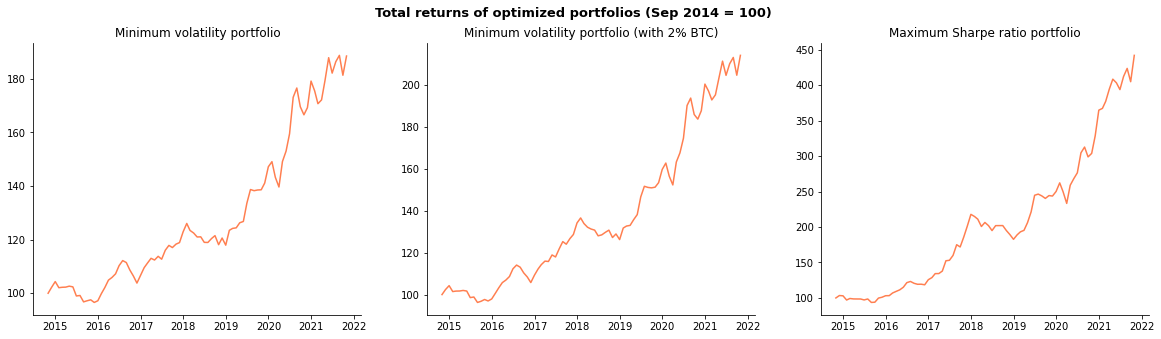

In [ ]:
#Illustrate the historic development for three "optimal" portfolios in a line chart
corr_df['Min vola ptf'] = min_vola_wghts['S&P 500']*corr_df['S&P 500'] + min_vola_wghts['Gold']*corr_df['Gold'] + min_vola_wghts['Bitcoin']*corr_df['Bitcoin']
corr_df['Max Sharpe ptf'] = max_SR_wghts['S&P 500']*corr_df['S&P 500'] + max_SR_wghts['Gold']*corr_df['Gold'] + max_SR_wghts['Bitcoin']*corr_df['Bitcoin']
corr_df['Min vola w. BTC ptf'] = min_volaBTC_wghts['S&P 500']*corr_df['S&P 500'] + min_volaBTC_wghts['Gold']*corr_df['Gold'] + min_volaBTC_wghts['Bitcoin']*corr_df['Bitcoin']

corr_df['Min vola ptf index'] = 100.0
corr_df['Max Sharpe ptf index'] = 100.0
corr_df['Min vola w. BTC ptf index'] = 100.0

for i in range(len(corr_df)-1):
  corr_df['Min vola ptf index'][i+1] = corr_df['Min vola ptf index'][i] * (1 + corr_df['Min vola ptf'][i+1])
  corr_df['Max Sharpe ptf index'][i+1] = corr_df['Max Sharpe ptf index'][i] * (1 + corr_df['Max Sharpe ptf'][i+1])
  corr_df['Min vola w. BTC ptf index'][i+1] = corr_df['Min vola w. BTC ptf index'][i] * (1 + corr_df['Min vola w. BTC ptf'][i+1])

fig, ax = plt.subplots(1,3, figsize=(20,5))
plt.suptitle('Total returns of optimized portfolios (Sep 2014 = 100)', fontweight='bold', fontsize=13)

ax[0].plot(corr_df.index, corr_df['Min vola ptf index'], color='coral')
ax[0].set_title('Minimum volatility portfolio')

ax[1].plot(corr_df.index, corr_df['Min vola w. BTC ptf index'], color='coral')
ax[1].set_title('Minimum volatility portfolio (with 2% BTC)')

ax[2].plot(corr_df.index, corr_df['Max Sharpe ptf index'], color='coral')
ax[2].set_title('Maximum Sharpe ratio portfolio')
chart_format(3)

A Monte Carlo simulation is a model used to predict the probability of a variety of outcomes when the potential for random variables is present. Monte Carlo simulations help to explain the impact of risk and uncertainty in prediction and forecasting models.

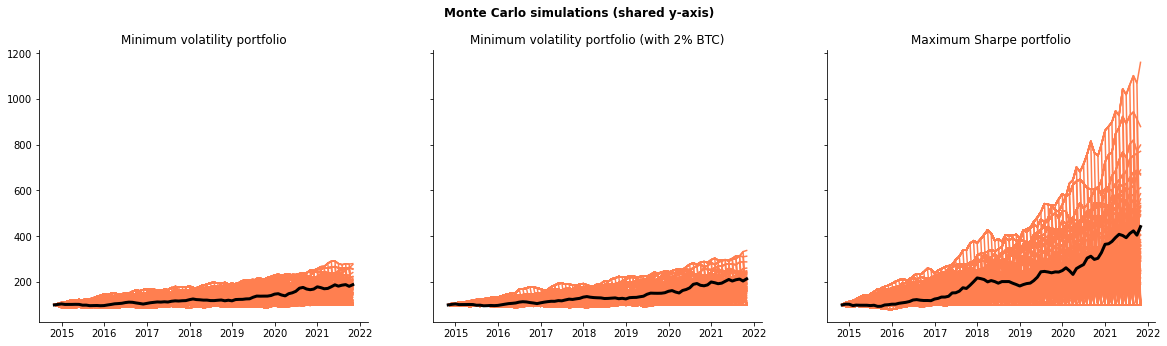

In [ ]:
# Add Monte Carlo simulation based on normal distribution for both portfolios (just 50 runs each for illustration)
fig, ax = plt.subplots(1, 3, figsize=(20,5), sharey=True)
plt.suptitle('Monte Carlo simulations (shared y-axis)',fontweight='bold',y=1.0)

ax[0].set_title('Minimum volatility portfolio')
ax[1].set_title('Minimum volatility portfolio (with 2% BTC)')
ax[2].set_title('Maximum Sharpe portfolio')
chart_format(3)

np.random.seed(1)
for i in range(50):
  s = np.random.normal((1 + min_vola_ptf[0])**(1/12) - 1, min_vola_ptf[1] / (12**0.5), 85)
  corr_df['random'] = s
  corr_df['random index'] = 100.0
  for j in range(len(corr_df) - 1):
    corr_df['random index'][j + 1] = corr_df['random index'][j]*(1 + corr_df['random'][j + 1])
    ax[0].plot(corr_df.index, corr_df['random index'], color='coral')
    
for i in range(50):
  s = np.random.normal((1 + min_volaBTC_ptf[0])**(1/12) - 1, min_volaBTC_ptf[1] / (12**0.5), 85)
  corr_df['random'] = s
  corr_df['random index'] = 100.0
  for j in range(len(corr_df) - 1):
    corr_df['random index'][j + 1] = corr_df['random index'][j]*(1 + corr_df['random'][j + 1])
    ax[1].plot(corr_df.index, corr_df['random index'], color='coral')

for i in range(50):
  s = np.random.normal((1 + max_SR_ptf[0])**(1/12) - 1, max_SR_ptf[1] / (12**0.5), 85)
  corr_df['random'] = s
  corr_df['random index'] = 100.0
  for j in range(len(corr_df) - 1):
    corr_df['random index'][j + 1] = corr_df['random index'][j]*(1 + corr_df['random'][j + 1])
    ax[2].plot(corr_df.index, corr_df['random index'], color='coral')

ax[0].plot(corr_df.index, corr_df['Min vola ptf index'], color='black', linewidth=2)
ax[1].plot(corr_df.index, corr_df['Min vola w. BTC ptf index'], color='black', linewidth=2)
ax[2].plot(corr_df.index, corr_df['Max Sharpe ptf index'], color='black', linewidth=2)

▶ **Insights:**
* The "cone" of possible outcomes for the maximum Sharpe ratio portfolio (with its 13% Bitcoin allocation) is pretty wide (ranging roughly from +100% to +1100% over the period). 
* Scenarios for the "middle ground" portfolio, minimizing volatility under a 2% Bitcoin allocation constraint, are reasonably close to the minimum volatility portfolio (ranging roughly from 0% to +200%), corroborating our view that the risk profile is not materially changed by this small Bitcoin allocation.

## **3. RECOMMENDATIONS**
* The motivating question of this report was to recommend an allocation to Bitcoin as part of a 3-asset portfolio. Given the very high historic volatility of Bitcoin and its limited diversification value versus equities, there is no place for Bitcoin, if the goal is to strictly minimize the fund's volatility.
* But to acknowledge the superior returns and high Sharpe ratio that Bitcoin has shown so far, the firm should still consider a small fixed allocation of 2% to Bitcoin, alongside 42% in S&P 500 and 56% in gold. Since 2014, such an allocation would have increased volatility relatively little compared to the minimum volatility portfolio (from 8.7% to 9%), while significantly improving returns (from 8.6% to 10.4%) and the Sharpe ratio (from 1 to 1.15). It has the additional benefit of offering a way to gain further hands-on experience with investing in Bitcoin, while conducting further analysis.
* Due to the backward-looking nature of this analysis, I strongly suggest complementing it with more forward-looking research. The results of the past 7 years cannot simply be extrapolated, especially considering the "youth" of Bitcoin as a mainstream investment and its gain in popularity over this period. Whether returns of 100% p.a. can be repeated seems highly uncertain, to say the least. Important areas for further research include: 1) the fundamental case for Bitcoin as a viable asset class (i.e. will it survive in the long run?);
2) valuation approaches to Bitcoin to estimate long-term forward-looking returns as part of a comprehensive set of capital market assumptions and; 
3) implementation challenges of Bitcoin (e.g. its very high intraday volatility; costs and benefits of direct vs. indirect investments).